In [2]:
import cv2
from scipy.signal import find_peaks, convolve2d

from fastai2.vision.all import *

In [3]:
dblock = DataBlock(blocks = (ImageBlock, CategoryBlock),
                  get_items = get_image_files,
                  get_y = parent_label,
                  splitter = RandomSplitter(),
                  item_tfms = Resize(224),
                  batch_tfms=aug_transforms(size=224))

In [4]:
squares = Path('combined')

In [5]:
dsets = dblock.datasets(squares)
dsets.train[0]

(PILImage mode=RGB size=117x117, TensorCategory(3))

In [6]:
dls = dblock.dataloaders(squares)

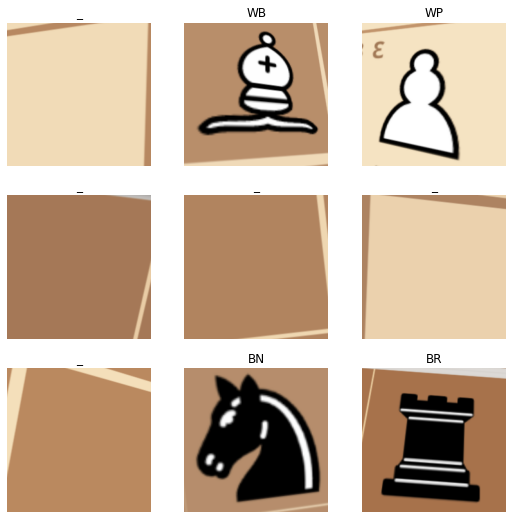

In [7]:
dls.show_batch()

In [10]:
model = cnn_learner(dls, resnet18, pretrained=False, metrics=error_rate)

In [12]:
model.fit(3)

epoch,train_loss,valid_loss,error_rate,time
0,0.059860,0.009419,0.000000,00:10
1,0.062563,0.004862,0.000000,00:10
2,0.056581,0.003790,0.000000,00:10


In [13]:
model.export('combined2.pkl')

## Predict

In [12]:
from ipywidgets import widgets
import chess

In [39]:
label_lib = {
                'WK':'K',
                'WQ':'Q',
                'WR':'R',
                'WB':'B',
                'WN':'N',
                'WP':'P',
                'BK':'k',
                'BQ':'q',
                'BR':'r',
                'BB':'b',
                'BN':'n',
                'BP':'p',
                '_' :'_'
            }

In [13]:
uploader = widgets.FileUpload()
uploader

FileUpload(value={}, description='Upload')

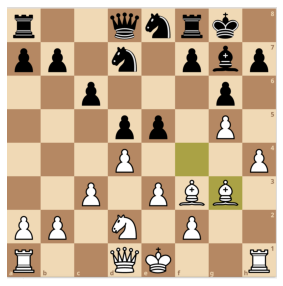

In [14]:
img = PILImage.create(uploader.data[0])
img.show()

In [2]:
path = Path('boards')

In [3]:
fn = path.ls()[0]

In [4]:
fn

Path('boards/rnbqkbnrpp_ppppp__________p_________P___________PPPP_PPPRNBQKBNR.png')

In [5]:
img = PILImage.create(fn)

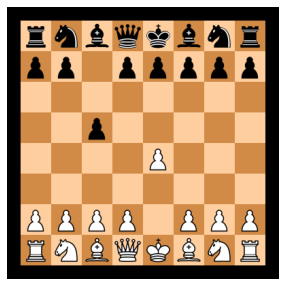

In [6]:
img.show()

In [43]:
def save_squares(img, hticks, vticks):
    k = 0
    for i in range(len(hticks)-1):
        for j in range(len(vticks)-1):
            xmin = hticks[i]
            xmax = hticks[i+1]
            ymin = vticks[j]
            ymax = vticks[j+1]
            square = img[xmin:xmax, ymin:ymax]
            cv2.imwrite(f'temp/{k}.png', square)
            k+=1

In [44]:
def make_squares(path):
    img = cv2.imread(path)

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    horiz = np.array([[1,2,1],
                         [0,0,0],
                         [-1,-2,-1]])

    vert = np.array([[1,0,-1],
                     [2,0,-2],
                     [1,0,-1]])

    # blur
    blurred = cv2.blur(gray,(3,3))

    # horizontal and vertical Sobel
    hgrad = convolve2d(blurred, horiz)
    vgrad = convolve2d(blurred, vert)

    # erode
    k = np.ones((3,3), np.uint8)
    hgrad = cv2.erode(hgrad.astype(np.uint8), k)
    vgrad = cv2.erode(vgrad.astype(np.uint8), k)

    # sum absolute values vertically and horizontally
    vlines = np.abs(vgrad).sum(axis=0)
    hlines = np.abs(hgrad).sum(axis=1)
    
    vlines = np.clip((vlines - vlines.max()/2),0,None)
    hlines = np.clip((hlines - hlines.max()/2),0,None)

    vticks = find_peaks(vlines)[0]
    hticks = find_peaks(hlines)[0]
    
    print(vticks,hticks)

    if len(vticks)==9 and len(hticks)==9:
        save_squares(img, hticks, vticks)
    else:
        print(f"Board {path} didn't validate")

In [45]:
img = cv2.imread(str(fn))

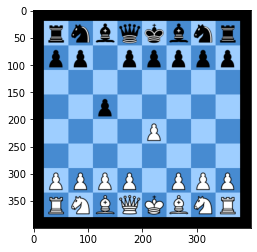

In [46]:
plt.imshow(img)

In [49]:
make_squares(str(fn))

[ 20  65 110 155 201 245 290 335 380] [ 20  65 110 155 200 245 290 335 380]


In [35]:
item_list = []
for y in range(8):
    for x in range(8):
        box = (x*w/8, y*h/8, (x+1)*w/8, (y+1)*h/8 ) # left, top, right, bottom
        cropped = img.crop(box)
        square = PILImage.create(cropped.to_bytes_format())
        item_list.append(square)

In [50]:
learner = load_learner('export.pkl')

In [37]:
dl = learner.dls.test_dl()
_, __, preds = learner.get_preds(dl=dl, with_decoded=True)

In [38]:
classes = learner.dls.vocab
preds = [classes[pred] for pred in preds]

In [22]:
label_lib = {
                'WK':'K',
                'WQ':'Q',
                'WR':'R',
                'WB':'B',
                'WN':'N',
                'WP':'P',
                'BK':'k',
                'BQ':'q',
                'BR':'r',
                'BB':'b',
                'BN':'n',
                'BP':'p',
                '_' :'_'
            }

In [40]:
labels = ''.join([label_lib[pred] for pred in preds])

In [41]:
labels

'nnnnnnnn_B_nnnnnQBQnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnn'

In [42]:
def trans_rank(rank):
    new_rank = ''
    empty_counter = 0
    for ch in rank:
        if ch == '_':
            empty_counter+=1
        else:
            if empty_counter>0:
                new_rank += str(empty_counter)
                empty_counter = 0
            new_rank += ch
    if empty_counter > 0:
        new_rank += str(empty_counter)
    return new_rank

def label2fen(label):
    ranks = [trans_rank(label[i:i+8]) for i in range(0, 64, 8)]
    return '/'.join(ranks)

In [43]:
fen = label2fen(labels)
fen

'nnnnnnnn/1B1nnnnn/QBQnnnnn/nnnnnnnn/nnnnnnnn/nnnnnnnn/nnnnnnnn/nnnnnnnn'

In [44]:
board = chess.Board(fen)

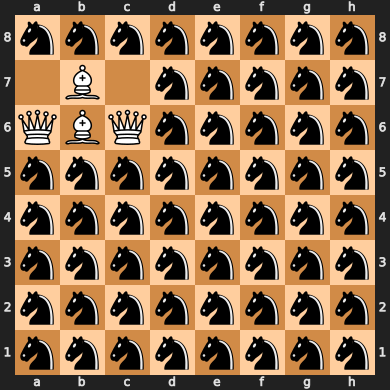

In [45]:
board

## Predict Functions

In [3]:
learner = load_learner('export.pkl')
classes = learner.dls.vocab

In [21]:
path_img = Path('squares')

In [24]:
type(learner.model.float())

torch.nn.modules.container.Sequential

In [25]:
type(trace_input)

torch.Tensor

In [26]:
# export model to TorchScript format
trace_input = torch.ones(1,3,224,224).cuda()
jit_model = torch.jit.trace(learner.model.float(), trace_input)
model_file='resnet18_jit.pth'
output_path = str(path_img/f'models/{model_file}')
torch.jit.save(jit_model, output_path)
# export classes text file
save_texts(path_img/'models/classes.txt', classes)
tar_file=path_img/'models/model.tar.gz'
classes_file='classes.txt'
# create a tarfile with the exported model and classes text file
with tarfile.open(tar_file, 'w:gz') as f:
    f.add(path_img/f'models/{model_file}', arcname=model_file)
    f.add(path_img/f'models/{classes_file}', arcname=classes_file)

RuntimeError: [enforce fail at inline_container.cc:348] . PytorchStreamWriter failed writing file version: file write failed
frame #0: c10::ThrowEnforceNotMet(char const*, int, char const*, std::string const&, void const*) + 0x5b (0x7f318da073bb in /opt/conda/envs/fastai/lib/python3.7/site-packages/torch/lib/libc10.so)
frame #1: caffe2::serialize::PyTorchStreamWriter::valid(char const*, char const*) + 0x7f (0x7f3196c81f4f in /opt/conda/envs/fastai/lib/python3.7/site-packages/torch/lib/libtorch.so)
frame #2: caffe2::serialize::PyTorchStreamWriter::writeRecord(std::string const&, void const*, unsigned long, bool) + 0x191 (0x7f3196c82e11 in /opt/conda/envs/fastai/lib/python3.7/site-packages/torch/lib/libtorch.so)
frame #3: caffe2::serialize::PyTorchStreamWriter::setup(std::string const&) + 0x19e (0x7f3196c8414e in /opt/conda/envs/fastai/lib/python3.7/site-packages/torch/lib/libtorch.so)
frame #4: caffe2::serialize::PyTorchStreamWriter::PyTorchStreamWriter(std::string) + 0x194 (0x7f3196c845d4 in /opt/conda/envs/fastai/lib/python3.7/site-packages/torch/lib/libtorch.so)
frame #5: torch::jit::ExportModule(torch::jit::script::Module const&, std::string const&, std::unordered_map<std::string, std::string, std::hash<std::string>, std::equal_to<std::string>, std::allocator<std::pair<std::string const, std::string> > > const&, bool) + 0x36 (0x7f31982db9b6 in /opt/conda/envs/fastai/lib/python3.7/site-packages/torch/lib/libtorch.so)
frame #6: <unknown function> + 0x777bb2 (0x7f31d8abebb2 in /opt/conda/envs/fastai/lib/python3.7/site-packages/torch/lib/libtorch_python.so)
frame #7: <unknown function> + 0x28ba06 (0x7f31d85d2a06 in /opt/conda/envs/fastai/lib/python3.7/site-packages/torch/lib/libtorch_python.so)
frame #8: _PyMethodDef_RawFastCallDict + 0x24d (0x55c2b58f8c4d in /opt/conda/envs/fastai/bin/python)
frame #9: _PyCFunction_FastCallDict + 0x21 (0x55c2b58f8dd1 in /opt/conda/envs/fastai/bin/python)
frame #10: _PyObject_Call_Prepend + 0x63 (0x55c2b58f6b63 in /opt/conda/envs/fastai/bin/python)
frame #11: PyObject_Call + 0x62 (0x55c2b58e9522 in /opt/conda/envs/fastai/bin/python)
frame #12: _PyEval_EvalFrameDefault + 0x1e53 (0x55c2b5991243 in /opt/conda/envs/fastai/bin/python)
frame #13: _PyEval_EvalCodeWithName + 0x2f9 (0x55c2b58d7749 in /opt/conda/envs/fastai/bin/python)
frame #14: _PyFunction_FastCallKeywords + 0x387 (0x55c2b5927527 in /opt/conda/envs/fastai/bin/python)
frame #15: _PyEval_EvalFrameDefault + 0x14e7 (0x55c2b59908d7 in /opt/conda/envs/fastai/bin/python)
frame #16: _PyEval_EvalCodeWithName + 0x2f9 (0x55c2b58d7749 in /opt/conda/envs/fastai/bin/python)
frame #17: _PyFunction_FastCallKeywords + 0x325 (0x55c2b59274c5 in /opt/conda/envs/fastai/bin/python)
frame #18: _PyEval_EvalFrameDefault + 0x4c89 (0x55c2b5994079 in /opt/conda/envs/fastai/bin/python)
frame #19: _PyEval_EvalCodeWithName + 0x2f9 (0x55c2b58d7749 in /opt/conda/envs/fastai/bin/python)
frame #20: PyEval_EvalCodeEx + 0x44 (0x55c2b58d8674 in /opt/conda/envs/fastai/bin/python)
frame #21: PyEval_EvalCode + 0x1c (0x55c2b58d869c in /opt/conda/envs/fastai/bin/python)
frame #22: <unknown function> + 0x1dd06d (0x55c2b599f06d in /opt/conda/envs/fastai/bin/python)
frame #23: _PyMethodDef_RawFastCallKeywords + 0xe9 (0x55c2b5927ba9 in /opt/conda/envs/fastai/bin/python)
frame #24: _PyCFunction_FastCallKeywords + 0x21 (0x55c2b5927e41 in /opt/conda/envs/fastai/bin/python)
frame #25: _PyEval_EvalFrameDefault + 0x48d4 (0x55c2b5993cc4 in /opt/conda/envs/fastai/bin/python)
frame #26: _PyGen_Send + 0x2a2 (0x55c2b5930b12 in /opt/conda/envs/fastai/bin/python)
frame #27: _PyEval_EvalFrameDefault + 0x1adc (0x55c2b5990ecc in /opt/conda/envs/fastai/bin/python)
frame #28: _PyGen_Send + 0x2a2 (0x55c2b5930b12 in /opt/conda/envs/fastai/bin/python)
frame #29: _PyEval_EvalFrameDefault + 0x1adc (0x55c2b5990ecc in /opt/conda/envs/fastai/bin/python)
frame #30: _PyGen_Send + 0x2a2 (0x55c2b5930b12 in /opt/conda/envs/fastai/bin/python)
frame #31: _PyMethodDef_RawFastCallKeywords + 0x8d (0x55c2b5927b4d in /opt/conda/envs/fastai/bin/python)
frame #32: _PyMethodDescr_FastCallKeywords + 0x4f (0x55c2b592f94f in /opt/conda/envs/fastai/bin/python)
frame #33: _PyEval_EvalFrameDefault + 0x4ddd (0x55c2b59941cd in /opt/conda/envs/fastai/bin/python)
frame #34: _PyFunction_FastCallKeywords + 0xfb (0x55c2b592729b in /opt/conda/envs/fastai/bin/python)
frame #35: _PyEval_EvalFrameDefault + 0x416 (0x55c2b598f806 in /opt/conda/envs/fastai/bin/python)
frame #36: _PyFunction_FastCallKeywords + 0xfb (0x55c2b592729b in /opt/conda/envs/fastai/bin/python)
frame #37: _PyEval_EvalFrameDefault + 0x6a0 (0x55c2b598fa90 in /opt/conda/envs/fastai/bin/python)
frame #38: _PyEval_EvalCodeWithName + 0x2f9 (0x55c2b58d7749 in /opt/conda/envs/fastai/bin/python)
frame #39: _PyFunction_FastCallDict + 0x400 (0x55c2b58d8ab0 in /opt/conda/envs/fastai/bin/python)
frame #40: _PyObject_Call_Prepend + 0x63 (0x55c2b58f6b63 in /opt/conda/envs/fastai/bin/python)
frame #41: PyObject_Call + 0x62 (0x55c2b58e9522 in /opt/conda/envs/fastai/bin/python)
frame #42: _PyEval_EvalFrameDefault + 0x1e53 (0x55c2b5991243 in /opt/conda/envs/fastai/bin/python)
frame #43: _PyEval_EvalCodeWithName + 0x5da (0x55c2b58d7a2a in /opt/conda/envs/fastai/bin/python)
frame #44: _PyFunction_FastCallKeywords + 0x387 (0x55c2b5927527 in /opt/conda/envs/fastai/bin/python)
frame #45: _PyEval_EvalFrameDefault + 0x14e7 (0x55c2b59908d7 in /opt/conda/envs/fastai/bin/python)
frame #46: <unknown function> + 0x16e5d9 (0x55c2b59305d9 in /opt/conda/envs/fastai/bin/python)
frame #47: _PyMethodDef_RawFastCallKeywords + 0xe9 (0x55c2b5927ba9 in /opt/conda/envs/fastai/bin/python)
frame #48: _PyCFunction_FastCallKeywords + 0x21 (0x55c2b5927e41 in /opt/conda/envs/fastai/bin/python)
frame #49: _PyEval_EvalFrameDefault + 0x48d4 (0x55c2b5993cc4 in /opt/conda/envs/fastai/bin/python)
frame #50: _PyEval_EvalCodeWithName + 0x5da (0x55c2b58d7a2a in /opt/conda/envs/fastai/bin/python)
frame #51: _PyFunction_FastCallKeywords + 0x387 (0x55c2b5927527 in /opt/conda/envs/fastai/bin/python)
frame #52: _PyEval_EvalFrameDefault + 0x6a0 (0x55c2b598fa90 in /opt/conda/envs/fastai/bin/python)
frame #53: <unknown function> + 0x16e5d9 (0x55c2b59305d9 in /opt/conda/envs/fastai/bin/python)
frame #54: _PyMethodDef_RawFastCallKeywords + 0xe9 (0x55c2b5927ba9 in /opt/conda/envs/fastai/bin/python)
frame #55: _PyCFunction_FastCallKeywords + 0x21 (0x55c2b5927e41 in /opt/conda/envs/fastai/bin/python)
frame #56: _PyEval_EvalFrameDefault + 0x48d4 (0x55c2b5993cc4 in /opt/conda/envs/fastai/bin/python)
frame #57: _PyEval_EvalCodeWithName + 0x5da (0x55c2b58d7a2a in /opt/conda/envs/fastai/bin/python)
frame #58: _PyFunction_FastCallKeywords + 0x387 (0x55c2b5927527 in /opt/conda/envs/fastai/bin/python)
frame #59: _PyEval_EvalFrameDefault + 0x416 (0x55c2b598f806 in /opt/conda/envs/fastai/bin/python)
frame #60: <unknown function> + 0x16e5d9 (0x55c2b59305d9 in /opt/conda/envs/fastai/bin/python)
frame #61: _PyMethodDef_RawFastCallKeywords + 0xe9 (0x55c2b5927ba9 in /opt/conda/envs/fastai/bin/python)
frame #62: _PyCFunction_FastCallKeywords + 0x21 (0x55c2b5927e41 in /opt/conda/envs/fastai/bin/python)
frame #63: _PyEval_EvalFrameDefault + 0x48d4 (0x55c2b5993cc4 in /opt/conda/envs/fastai/bin/python)


In [81]:
label_lib = {
                'WK':'K',
                'WQ':'Q',
                'WR':'R',
                'WB':'B',
                'WN':'N',
                'WP':'P',
                'BK':'k',
                'BQ':'q',
                'BR':'r',
                'BB':'b',
                'BN':'n',
                'BP':'p',
                '_' :'_'
            }

In [82]:
def trans_rank(rank):
    new_rank = ''
    empty_counter = 0
    for ch in rank:
        if ch == '_':
            empty_counter+=1
        else:
            if empty_counter>0:
                new_rank += str(empty_counter)
                empty_counter = 0
            new_rank += ch
    if empty_counter > 0:
        new_rank += str(empty_counter)
    return new_rank

def label2fen(label):
    ranks = [trans_rank(label[i:i+8]) for i in range(0, 64, 8)]
    return '/'.join(ranks)

In [83]:
def predict_board(img):
    item_list = []
    for y in range(8):
        for x in range(8):
            box = (x*w/8, y*h/8, (x+1)*w/8, (y+1)*h/8 ) # left, top, right, bottom
            cropped = img.crop(box)
            square = PILImage.create(cropped.to_bytes_format())
            item_list.append(square) 

    dl = learner.dls.test_dl(item_list)
    _, __, preds = learner.get_preds(dl=dl, with_decoded=True)
    preds = [classes[pred] for pred in preds]
    labels = ''.join([label_lib[pred] for pred in preds])
    fen = label2fen(labels)
    
    return fen

In [73]:
uploader = widgets.FileUpload()
uploader

FileUpload(value={}, description='Upload')

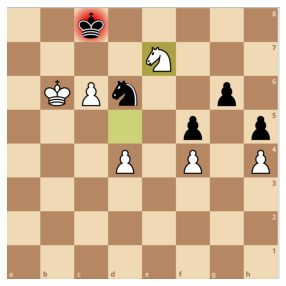

In [80]:
img = PILImage.create(uploader.data[0])
img.show()

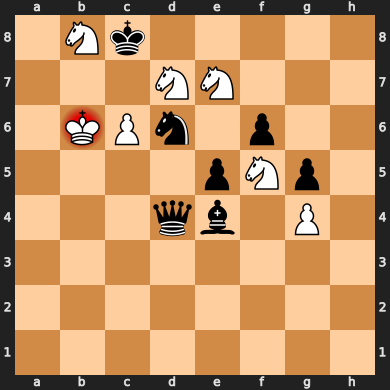

In [85]:
fen = predict_board(img)
board = chess.Board(fen)
board

In [ ]:
dblock.dataloaders()